In [1]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
import requests
import yfinance as yf
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
#from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

In [2]:
#read csv data from IPO Scoop into a dataframe and set the company Symbol as the index
#other columns include industry type, amount of shares in millions, initial offer price, closing on the first day
#current price and returns, and then dropping the 1st day close column
ipo_csv = pd.read_csv('IpoScoop.csv')
filtered_ipo=ipo_csv.drop(columns=["1st Day Close"])
filtered_ipo.set_index('Symbol',inplace=True)

<AxesSubplot:ylabel='Industry'>

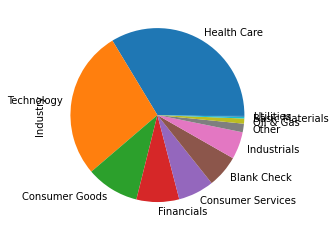

In [3]:
#visualization of different industries
sector_count = filtered_ipo["Industry"].value_counts()
sector_count.plot(kind="pie")

In [8]:
filtered_ipo["Offer Date"]=pd.to_datetime(filtered_ipo["Offer Date"], infer_datetime_format=True)
filter_ipo=filtered_ipo.drop(["MTAL.U"])
filter_ipo.head()

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return
Symbol,,,,,,,
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$19.00,375.00%
APLD,"Applied Blockchain, Inc.",Technology,2022-04-13,8.0,$5.00,$4.02,-19.60%
EE,"Excelerate Energy, Inc.",Oil & Gas,2022-04-13,16.0,$24.00,$24.20,0.83%
GNS,Genius Group Limited,Consumer Services,2022-04-12,3.3,$6.00,$6.23,3.83%
XPON,Expion360 Inc.,Industrials,2022-04-01,2.2,$7.00,$4.15,-40.71%


In [ ]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
ten_days = pd.to_timedelta(10,'days')
three_months = pd.to_timedelta(84,'days')
hundred_days = pd.to_timedelta(100,'days')
filter_ipo['T-10Days'] = filter_ipo['Offer Date']-ten_days
filter_ipo['T-90Days'] = filter_ipo['Offer Date']-three_months
filter_ipo['T+100Days'] = filter_ipo['Offer Date']+hundred_days

In [ ]:
#convert to string for yf useage
filter_ipo['T-10Days'] = filter_ipo['T-10Days'].astype(str)
filter_ipo['T-90Days'] = filter_ipo['T-90Days'].astype(str)
filter_ipo['T+100Days'] = filter_ipo['T+100Days'].astype(str)

In [ ]:
#calculating returns using the new specific times (100 day period) from yahoo finance api get data
for ticker in filter_ipo.index:
    data=yf.download("SPY",filter_ipo.loc[ticker,'T-90Days'], filter_ipo.loc[ticker,'T-10Days'],progress=True)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    filter_ipo.loc[ticker,'SPY 90D Return'] = spy_return
    data2=yf.download(ticker,filter_ipo.loc[ticker,'Offer Date'], filter_ipo.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo.loc[ticker,'100 day Return'] = stock_return

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
#checking output
display(filter_ipo)

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return
Symbol,,,,,,,,,,,,
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$19.00,375.00%,2022-04-12,2022-01-28,2022-07-31,-0.004593,-0.780526
APLD,"Applied Blockchain, Inc.",Technology,2022-04-13,8.0,$5.00,$4.02,-19.60%,2022-04-03,2022-01-19,2022-07-22,0.005705,-0.292783
EE,"Excelerate Energy, Inc.",Oil & Gas,2022-04-13,16.0,$24.00,$24.20,0.83%,2022-04-03,2022-01-19,2022-07-22,0.005705,0.014898
GNS,Genius Group Limited,Consumer Services,2022-04-12,3.3,$6.00,$6.23,3.83%,2022-04-02,2022-01-18,2022-07-21,-0.004738,-0.804590
XPON,Expion360 Inc.,Industrials,2022-04-01,2.2,$7.00,$4.15,-40.71%,2022-03-22,2022-01-07,2022-07-10,-0.043596,-0.535939
...,...,...,...,...,...,...,...,...,...,...,...,...
AGTI,"Agiliti, Inc.",Health Care,2021-04-23,26.3,$14.00,$20.16,44.00%,2021-04-13,2021-01-29,2021-08-01,0.115973,0.194512
IMPL,Impel NeuroPharma,Health Care,2021-04-23,5.3,$15.00,$6.11,-59.27%,2021-04-13,2021-01-29,2021-08-01,0.115973,-0.062667
SWIM,"Latham Group, Inc.",Consumer Goods,2021-04-23,20.0,$19.00,$12.01,-36.79%,2021-04-13,2021-01-29,2021-08-01,0.115973,0.001101


In [ ]:
filter_ipo_1=filter_ipo.drop(columns=["Company","Offer Date","Shares (millions)","Offer Price","Current Price","T-10Days","T-90Days","T+100Days"])

In [ ]:
filter_ipo_1.count()
filter_ipo_1.isnull().sum()


TypeError: 'Series' object is not callable

In [ ]:
display(filter_ipo_1)

,Industry,Return,SPY 90D Return,100 day Return
Symbol,,,,
JCSE,Industrials,375.00%,-0.004593,-0.780526
APLD,Technology,-19.60%,0.005705,-0.292783
EE,Oil & Gas,0.83%,0.005705,0.014898
GNS,Consumer Services,3.83%,-0.004738,-0.804590
XPON,Industrials,-40.71%,-0.043596,-0.535939
...,...,...,...,...
AGTI,Health Care,44.00%,0.115973,0.194512
IMPL,Health Care,-59.27%,0.115973,-0.062667
SWIM,Consumer Goods,-36.79%,0.115973,0.001101


In [ ]:
#Encoding "Industry" Column
le = LabelEncoder()
le.fit(filter_ipo_1["Industry"])
filter_ipo_1["Industry"] = le.transform(filter_ipo_1["Industry"])
display(filter_ipo_1)

,Industry,Return,SPY 90D Return,100 day Return
Symbol,,,,
JCSE,6,375.00%,-0.004593,-0.780526
APLD,9,-19.60%,0.005705,-0.292783
EE,7,0.83%,0.005705,0.014898
GNS,3,3.83%,-0.004738,-0.804590
XPON,6,-40.71%,-0.043596,-0.535939
...,...,...,...,...
AGTI,5,44.00%,0.115973,0.194512
IMPL,5,-59.27%,0.115973,-0.062667
SWIM,2,-36.79%,0.115973,0.001101


In [ ]:
filter_ipo_1.dtypes

Industry            int64
Return             object
SPY 90D Return    float64
100 day Return    float64
dtype: object

In [ ]:

#Multiclassification problem
#K-means - Prabh 
#KNN- 
#Xgboost - Nitin
#Random Forest - Aman
#Mayes bias- Nitin 

#README- Matt
#SLIDES

# Create and train LR model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier.fit(X_train, y_train)

# Execute LR predictions
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()
# Create a confusion matrix
confusion_matrix(y_test, predictions)

# Create a classification report
target_names = ["No Diabetes", "Diabetes"]
print(classification_report(y_test, predictions, target_names=target_names))


#PCA MODEL
# Standarize data with StandarScaler
df_scaled = StandardScaler().fit_transform(bz_ipo_df)
print(df_scaled[0:5])
# Applying PCA to reduce dimensions from 4 to 2

# Initialize PCA model
pca = PCA(n_components=2)

# Get two principal components for the iris data.
df_pca = pca.fit_transform(df_scaled)

# Transform PCA data to a DataFrame
df__pca = pd.DataFrame(
    data=df_pca, columns=["principal component 1", "principal component 2"]
)
df__pca.head()

# Fetch the explained variance
pca.explained_variance_ratio_

# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df__pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

# Predicting clusters with k=3

# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(df__pca)

# Predict clusters
predictions = model.predict(df__pca)

# Add the predicted class columns
df__pca["class"] = model.labels_
df__pca.head()

# Plotting the clusters
df__pca.hvplot.scatter(
    x="principal component 1",
    y="principal component 2",
    hover_cols=["class"],
    by="class",
)


#for ticker in filter_ipo.index:
#filter_ipo.loc[ticker,'Offer Date'] = filter_ipo.loc[ticker,'Offer Date'].isocalendar()[1]

#filter_ipo['100 day Return'].clip(min=0)
#filter_ipo['100 day Return']<0 = 0

# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_neg = []
for pct in filter_ipo_1['100 day Return']:
    if pct >= 0:
        filter_ipo_1.append(1)
    else:
        filter_ipo_1.append(0)
        
filter_ipo_1['100 Day P/N'] = (filter_ipo_1['100 day Return'] > 0).astype(int)
filter_ipo_1.head()

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

In [ ]:
# disregard
# Drop unecessary date columns
#filtered_ipo.drop(columns=['T-10D','T-90D','T+100D'], inplace=True)
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
#bs_list = glob.glob("*_annual_balance-sheet.csv")
#cf_list = glob.glob("*_annual_cash-flow.csv")
#af_list = glob.glob("*_annual_financials.csv")
#list_of_lists = [bs_list,cf_list,af_list]
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, ipo_df],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
bz_ipo_df = bz_ipo_df.drop(columns='index')
309
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','').astype(float)
C:\Users\tjmcd\AppData\Local\Temp/ipykernel_32396/1029865757.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
# Drop 100 Day Returns column so that it doesn't wind up in training split
bz_ipo_df.drop(columns='100 day Return', inplace=True)
bz_ipo_df['100D Y/N'].value_counts()
0.0    214
1.0     92
Name: 100D Y/N, dtype: int64
bz_ipo_df.columns
Index(['TotalAssets', 'CurrentAssets',
       'CashCashEquivalentsAndShortTermInvestments', 'CashAndCashEquivalents',
       'Receivables', 'OtherReceivables', 'PrepaidAssets',
       'OtherCurrentAssets', 'TotalNonCurrentAssets',
       'NonCurrentDeferredAssets',
       ...
       'OtherOperatingExpenses', 'ReconciledCostOfRevenue',
       'SellingAndMarketingExpense', 'SpecialIncomeCharges', 'Industry',
       'Offer Date', 'Shares (millions)', 'Offer Price', 'SPY 90D Return',
       '100D Y/N'],
      dtype='object', length=201)
# Split and scale data
X = bz_ipo_df.iloc[:, 0:-1]
y = bz_ipo_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

SyntaxError: unexpected character after line continuation character (Temp/ipykernel_13544/1652896686.py, line 122)